<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/cabai_merah_keriting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [2]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import math

from keras.utils.vis_utils import plot_model
from tensorflow.data import Dataset
from tensorflow.keras.losses import Huber
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

## time step generator

In [3]:
def time_step_generator(data, time_size, batch_size, shuffle_data):
  dataset = Dataset.from_tensor_slices(data)
  dataset = dataset.window(time_size+1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda x: x.batch(time_size+1))
  dataset = dataset.shuffle(shuffle_data)
  dataset = dataset.map(lambda x: (x[:-1], x[-1]))
  return dataset.batch(batch_size).prefetch(1)

def forecast_predict(model, data, time_size, batch_size):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

## Load data

In [4]:
url ='https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_new.csv?raw=true'
urllib.request.urlretrieve(url, 'data_pangan.csv')

('data_pangan.csv', <http.client.HTTPMessage at 0x7fd27fce9eb0>)

In [5]:
dataset = pd.read_csv('data_pangan.csv')
dataset.head()

,date,beras,beras_kualitas_bawah_i,beras_kualitas_bawah_ii,beras_kualitas_medium_i,beras_kualitas_medium_ii,beras_kualitas_super_i,beras_kualitas_super_ii,daging_ayam_ras_segar,daging_sapi_kualitas_1,...,cabai_rawit,cabai_rawit_hijau,cabai_rawit_merah,minyak_goreng,minyak_goreng_curah,minyak_goreng_kemasan_bermerk_1,minyak_goreng_kemasan_bermerk_2,gula_pasir,gula_pasir_kualitas_premium,gula_pasir_lokal
0,2017-01-08,11200,10150,9650,11250,11150,12750,12250,34100,118400,...,41050,34800,47550,13950,12250,15050,14350,14900,16800,13250
1,2017-01-11,11400,10350,9900,11500,11300,12900,12350,30350,117000,...,30000,30000,30450,13900,12250,14950,14300,14500,16550,12900
2,2017-01-12,10700,9650,8500,11200,10950,12250,11850,29350,115800,...,33300,31500,35050,14000,12150,15400,14400,14800,16650,12950
3,2017-02-08,11200,10150,9650,11250,11150,12750,12250,34150,118400,...,40600,34600,46650,13950,12250,15050,14350,14900,16800,13250
4,2017-02-10,11400,10250,9850,11400,11250,12850,12350,30200,118400,...,31850,32550,31550,14000,12350,15000,14350,14700,16750,12950


In [6]:
dataset['date'] = pd.to_datetime(dataset['date'])

In [7]:
dataset = dataset.set_index('date')
dataset = dataset.sort_index()
train = dataset.cabai_merah_keriting_.values
date = dataset.index

## Train test val split

In [8]:
x_train, x_test, y_train, y_test = train_test_split(train, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.125, random_state=False, shuffle=False) # 0.125 x 0.48 = 0.1

print(f'{len(x_train)}\n{len(x_test)}')

818
234


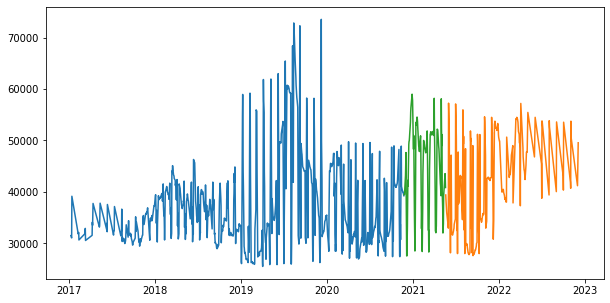

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(y_train, x_train)
plt.plot(y_test, x_test)
plt.plot(y_val, x_val)
plt.show()

## data generate

In [35]:
scal_range= MinMaxScaler(feature_range=(0,1))
train_scal = scal_range.fit_transform(x_train.reshape(-1, 1))
test_scal = scal_range.fit_transform(x_test.reshape(-1, 1))
val_scal = scal_range.fit_transform(x_val.reshape(-1, 1))
train_step = time_step_generator(train_scal, time_size=600, shuffle_data=100, batch_size=5)
val_step = time_step_generator(val_scal, time_size=80, shuffle_data=100, batch_size=20)
test_step = time_step_generator(test_scal, time_size=150, shuffle_data=1000, batch_size=5)

train_step1 = time_step_generator(train_scal, time_size=100, shuffle_data=100, batch_size=1)
val_step1 = time_step_generator(val_scal, time_size=1, shuffle_data=10, batch_size=1)
test_step1 = time_step_generator(test_scal, time_size=10, shuffle_data=100, batch_size=1)

train_step2 = time_step_generator(train_scal, time_size=400, shuffle_data=1000, batch_size=5)
val_step2 = time_step_generator(val_scal, time_size=50, shuffle_data=100, batch_size=2)
test_step2 = time_step_generator(test_scal, time_size=100, shuffle_data=1000, batch_size=5)

In [11]:
forecast = np.append(x_train, x_test)
forecast_date = np.append(y_train, y_test)
win_size= 400
win_size1 = 60
win_size2=150
test_cabaimerahkeriting_ = scal_range.fit_transform(forecast.reshape(-1, 1))

## model 

### SGD

In [12]:
model= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
    LSTM(24, return_sequences=True),
    LSTM(20),
    Dense(64, activation='relu'),
    Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 16)          48        
                                                                 
 lstm (LSTM)                 (None, None, 24)          3936      
                                                                 
 lstm_1 (LSTM)               (None, 20)                3600      
                                                                 
 dense (Dense)               (None, 64)                1344      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# plot_model(model, to_file='model1_plot.png', show_shapes=True, show_layer_names=True)

#### type1

In [13]:
history = model.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 15s 253ms/step - loss: 0.0668 - mae: 0.2182 - mape: 94.2804 - val_loss: 0.3389 - val_mae: 0.5344 - val_mape: 95.9478
Epoch 2/30
44/44 [==============================] - 8s 185ms/step - loss: 0.0523 - mae: 0.1830 - mape: 70.5438 - val_loss: 0.3022 - val_mae: 0.4989 - val_mape: 87.3982
Epoch 3/30
44/44 [==============================] - 8s 185ms/step - loss: 0.0422 - mae: 0.1574 - mape: 59.2485 - val_loss: 0.2748 - val_mae: 0.4706 - val_mape: 80.5793
Epoch 4/30
44/44 [==============================] - 8s 185ms/step - loss: 0.0352 - mae: 0.1410 - mape: 55.9982 - val_loss: 0.2539 - val_mae: 0.4479 - val_mape: 75.1225
Epoch 5/30
44/44 [==============================] - 8s 187ms/step - loss: 0.0302 - mae: 0.1297 - mape: 56.5792 - val_loss: 0.2364 - val_mae: 0.4279 - val_mape: 70.3123
Epoch 6/30
44/44 [==============================] - 8s 186ms/step - loss: 0.0265 - mae: 0.1237 - mape: 59.9343 - val_loss: 0.2234 - val_mae: 0.4123 - val_mape:

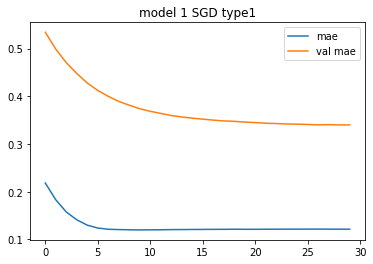

In [14]:
mae = history.history['mae']
val_mae = history.history['val_mae']
epoch = range(len(mae))

plt.title('model 1 SGD type1')
plt.plot(epoch, mae, label='mae')
plt.plot(epoch, val_mae, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 23ms/step
8116.082 18.452436 9851.610629739687


,date,actual,prediction
0,2021-05-20,39400,36591.500000
1,2021-05-21,38400,36567.433594
2,2021-05-24,36000,36603.277344
3,2021-05-25,35600,36570.609375
4,2021-05-27,34850,36595.921875
...,...,...,...
229,2022-11-02,40700,36730.152344
230,2022-11-03,53750,36724.589844
231,2022-11-04,50550,36736.585938
232,2022-12-01,41200,36731.343750


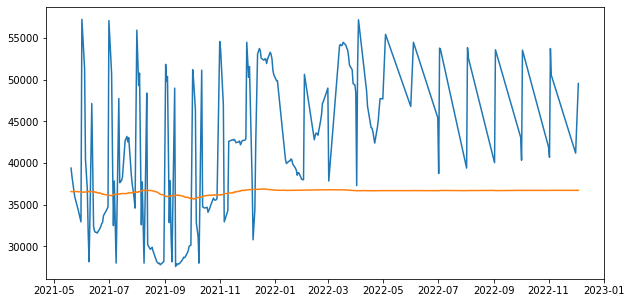

In [15]:
prediction = forecast_predict(model, test_cabaimerahkeriting_, time_size=win_size, batch_size=5)

data_result = prediction[(len(x_train))-win_size:-1, -1 ]
data_result = scal_range.inverse_transform(data_result.reshape(-1, 1))
data_result = data_result.reshape(-1)
mae= tf.keras.metrics.mean_absolute_error(x_test, data_result)
mape = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result)
mse = tf.keras.metrics.mean_squared_error(x_test, data_result)

rmse =math.sqrt(mse.numpy())
print(mae.numpy(), mape.numpy(), rmse)

data_new_cabaimerahkeriting = pd.DataFrame()
data_new_cabaimerahkeriting['date'] = y_test
data_new_cabaimerahkeriting['actual'] = x_test
data_new_cabaimerahkeriting['prediction'] = data_result
data_new_cabaimerahkeriting.to_csv('cabaimerahkeriting_model1_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(data_new_cabaimerahkeriting.date, data_new_cabaimerahkeriting.actual)
plt.plot(data_new_cabaimerahkeriting.date, data_new_cabaimerahkeriting.prediction)
data_new_cabaimerahkeriting

#### type2

In [16]:
history_t1 = model.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 27s 38ms/step - loss: 0.0330 - mae: 0.1374 - mape: 384381.3750 - val_loss: 0.1264 - val_mae: 0.3017 - val_mape: 52.3313
Epoch 2/30
718/718 [==============================] - 26s 36ms/step - loss: 0.0320 - mae: 0.1361 - mape: 306430.2500 - val_loss: 0.1194 - val_mae: 0.2923 - val_mape: 51.4492
Epoch 3/30
718/718 [==============================] - 26s 36ms/step - loss: 0.0316 - mae: 0.1356 - mape: 294807.8438 - val_loss: 0.1144 - val_mae: 0.2854 - val_mape: 50.9045
Epoch 4/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0314 - mae: 0.1347 - mape: 358572.4688 - val_loss: 0.1161 - val_mae: 0.2878 - val_mape: 51.2071
Epoch 5/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0313 - mae: 0.1348 - mape: 353374.6562 - val_loss: 0.1102 - val_mae: 0.2797 - val_mape: 50.5167
Epoch 6/30
718/718 [==============================] - 25s 34ms/step - loss: 0.0310 - mae: 0.1339 - mape: 282821.3438 - val_loss: 0

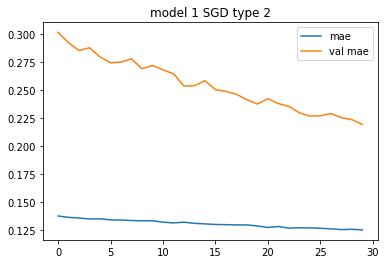

In [17]:
mae_t1 = history_t1.history['mae']
val_mae_t1 = history_t1.history['val_mae']
epoch_t1 = range(len(mae_t1))

plt.title('model 1 SGD type 2')
plt.plot(epoch_t1, mae_t1, label='mae')
plt.plot(epoch_t1, val_mae_t1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 6ms/step
6560.1484 15.671632 7920.780517095522


,date,actual,prediction
0,2021-05-20,39400,36591.500000
1,2021-05-21,38400,36567.433594
2,2021-05-24,36000,36603.277344
3,2021-05-25,35600,36570.609375
4,2021-05-27,34850,36595.921875
...,...,...,...
229,2022-11-02,40700,36730.152344
230,2022-11-03,53750,36724.589844
231,2022-11-04,50550,36736.585938
232,2022-12-01,41200,36731.343750


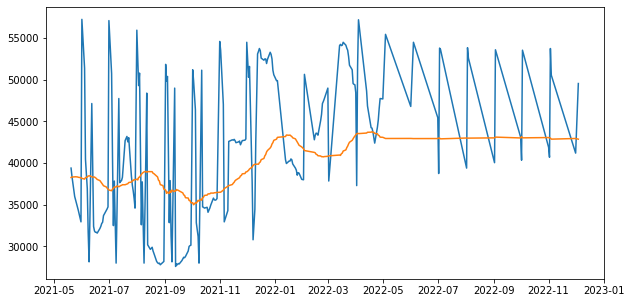

In [18]:
win_size1 = 60
test_cabaimerahkeriting_1 = scal_range.fit_transform(forecast.reshape(-1, 1))
prediction_1 = forecast_predict(model, test_cabaimerahkeriting_1, time_size=win_size1, batch_size=5)

data_result_1 = prediction_1[(len(x_train))-win_size1:-1, -1 ]
data_result_1 = scal_range.inverse_transform(data_result_1.reshape(-1, 1))
data_result_1 = data_result_1.reshape(-1)
mae_1= tf.keras.metrics.mean_absolute_error(x_test, data_result_1)
mape_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_1)
mse_1 = tf.keras.metrics.mean_squared_error(x_test, data_result_1)
rmse_1 =math.sqrt(mse_1.numpy())
print(mae_1.numpy(), mape_1.numpy(), rmse_1)

data_new_cabaimerahkeriting_1 = pd.DataFrame()
data_new_cabaimerahkeriting_1['actual'] = x_test
data_new_cabaimerahkeriting_1['prediction'] = data_result_1
data_new_cabaimerahkeriting_1.to_csv('cabaimerahkeriting_model1_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerahkeriting_1.actual)
plt.plot(y_test, data_new_cabaimerahkeriting_1.prediction)
data_new_cabaimerahkeriting

#### type3

In [19]:
history_t2 = model.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 10s 121ms/step - loss: 0.0361 - mae: 0.1488 - mape: 476722.0938 - val_loss: 0.0667 - val_mae: 0.2169 - val_mape: 49.3482
Epoch 2/30
84/84 [==============================] - 10s 120ms/step - loss: 0.0358 - mae: 0.1505 - mape: 498777.2188 - val_loss: 0.0654 - val_mae: 0.2153 - val_mape: 49.5706
Epoch 3/30
84/84 [==============================] - 10s 120ms/step - loss: 0.0358 - mae: 0.1507 - mape: 509799.6250 - val_loss: 0.0651 - val_mae: 0.2150 - val_mape: 49.6548
Epoch 4/30
84/84 [==============================] - 10s 122ms/step - loss: 0.0357 - mae: 0.1510 - mape: 516257.7500 - val_loss: 0.0648 - val_mae: 0.2147 - val_mape: 49.7148
Epoch 5/30
84/84 [==============================] - 10s 121ms/step - loss: 0.0357 - mae: 0.1512 - mape: 515329.4688 - val_loss: 0.0645 - val_mae: 0.2143 - val_mape: 49.8046
Epoch 6/30
84/84 [==============================] - 10s 123ms/step - loss: 0.0357 - mae: 0.1504 - mape: 513089.1250 - val_loss: 0.0643 

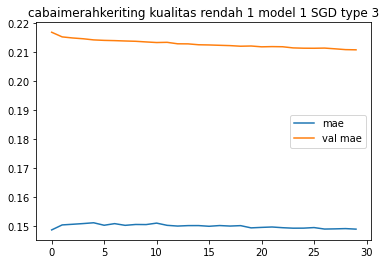

In [20]:
mae_t2 = history_t2.history['mae']
val_mae_t2 = history_t2.history['val_mae']
epoch_t2 = range(len(mae_t2))

plt.title('cabaimerahkeriting kualitas rendah 1 model 1 SGD type 3')
plt.plot(epoch_t2, mae_t2, label='mae')
plt.plot(epoch_t2, val_mae_t2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 10ms/step
6407.364 15.785117 7586.161875414998


,actual,prediction
0,39400,39245.789062
1,38400,39302.425781
2,36000,39322.398438
3,35600,39347.820312
4,34850,39321.386719
...,...,...
229,40700,45061.445312
230,53750,45016.097656
231,50550,44880.589844
232,41200,44965.804688


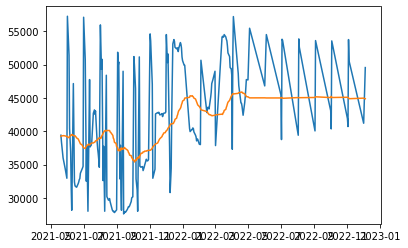

In [21]:
win_size2 = 150
prediction_2 = forecast_predict(model, test_cabaimerahkeriting_, time_size=win_size2, batch_size=5)

data_result_2 = prediction_2[(len(x_train))-win_size2:-1, -1 ]
data_result_2 = scal_range.inverse_transform(data_result_2.reshape(-1, 1))
data_result_2 = data_result_2.reshape(-1)
mae_2= tf.keras.metrics.mean_absolute_error(x_test, data_result_2)
mape_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_2)
mse_2 = tf.keras.metrics.mean_squared_error(x_test, data_result_2)

rmse_2 =math.sqrt(mse_2.numpy())
print(mae_2.numpy(), mape_2.numpy(), rmse_2)

data_new_cabaimerahkeriting_2 = pd.DataFrame()
# data_new_cabaimerahkeriting1['date'] = date_test
data_new_cabaimerahkeriting_2['actual'] = x_test
data_new_cabaimerahkeriting_2['prediction'] = data_result_2
data_new_cabaimerahkeriting_2.to_csv('cabaimerahkeriting_model1_sgd_type3')

plt.plot(y_test, data_new_cabaimerahkeriting_2.actual)
plt.plot(y_test, data_new_cabaimerahkeriting_2.prediction)
data_new_cabaimerahkeriting_2

### Adam

In [22]:
model_a= Sequential([
    Conv1D(16, kernel_size=2, activation='relu',padding='causal', strides=2, input_shape=[None, 1]),
        LSTM(24, return_sequences=True),
        LSTM(20),
        Dense(64, activation='relu'),
        Dense(1)
])

model_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model_a.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 16)          48        
                                                                 
 lstm_2 (LSTM)               (None, None, 24)          3936      
                                                                 
 lstm_3 (LSTM)               (None, 20)                3600      
                                                                 
 dense_2 (Dense)             (None, 64)                1344      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 8,993
Trainable params: 8,993
Non-trainable params: 0
_________________________________________________________________


#### Type 1

In [23]:
history_a = model_a.fit(train_step, epochs=30, validation_data=val_step)

Epoch 1/30
44/44 [==============================] - 13s 208ms/step - loss: 0.0582 - mae: 0.1977 - mape: 80.5271 - val_loss: 0.2597 - val_mae: 0.4540 - val_mape: 76.4529
Epoch 2/30
44/44 [==============================] - 8s 187ms/step - loss: 0.0361 - mae: 0.1431 - mape: 57.1335 - val_loss: 0.1510 - val_mae: 0.3327 - val_mape: 55.6719
Epoch 3/30
44/44 [==============================] - 8s 188ms/step - loss: 0.0193 - mae: 0.1133 - mape: 74.4813 - val_loss: 0.0748 - val_mae: 0.2269 - val_mape: 48.4405
Epoch 4/30
44/44 [==============================] - 8s 186ms/step - loss: 0.0178 - mae: 0.1190 - mape: 95.7089 - val_loss: 0.0772 - val_mae: 0.2299 - val_mape: 48.2118
Epoch 5/30
44/44 [==============================] - 8s 188ms/step - loss: 0.0176 - mae: 0.1173 - mape: 92.3332 - val_loss: 0.0762 - val_mae: 0.2287 - val_mape: 48.3432
Epoch 6/30
44/44 [==============================] - 8s 187ms/step - loss: 0.0176 - mae: 0.1179 - mape: 94.5053 - val_loss: 0.0745 - val_mae: 0.2267 - val_mape:

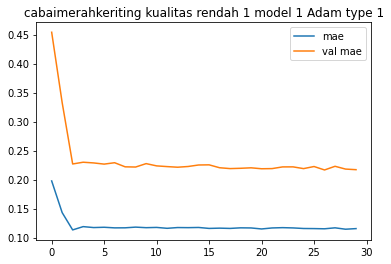

In [24]:
mae_a = history_a.history['mae']
val_mae_a = history_a.history['val_mae']
epoch_a = range(len(mae_a))

plt.title('cabaimerahkeriting kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a, mae_a, label='mae')
plt.plot(epoch_a, val_mae_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 4s 23ms/step
6548.206 15.534946 7965.765751012265


,actual,prediction
0,39400,38119.683594
1,38400,38031.769531
2,36000,38185.644531
3,35600,38094.109375
4,34850,38199.339844
...,...,...
229,40700,42910.175781
230,53750,43106.316406
231,50550,42780.125000
232,41200,43008.316406


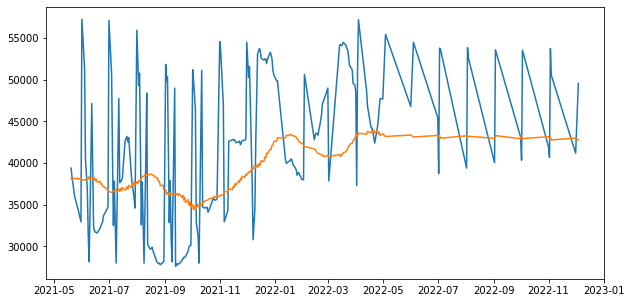

In [25]:
prediction_a = forecast_predict(model_a, test_cabaimerahkeriting_, time_size=win_size, batch_size=5)

data_result_a = prediction_a[(len(x_train))-win_size:-1, -1 ]
data_result_a = scal_range.inverse_transform(data_result_a.reshape(-1, 1))
data_result_a = data_result_a.reshape(-1)
mae_a= tf.keras.metrics.mean_absolute_error(x_test, data_result_a)
mape_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a)
mse_a = tf.keras.metrics.mean_squared_error(x_test, data_result_a)

rmse_a =math.sqrt(mse_a.numpy())
print(mae_a.numpy(), mape_a.numpy(), rmse_a)

data_new_cabaimerahkeriting_a = pd.DataFrame()
# data_new_cabaimerahkeriting1['date'] = date_test
data_new_cabaimerahkeriting_a['actual'] = x_test
data_new_cabaimerahkeriting_a['prediction'] = data_result_a
data_new_cabaimerahkeriting_a.to_csv('cabaimerahkeriting_model1_adam_type1.csv')

plt.figure(figsize=(10,5))
plt.plot(y_test, data_new_cabaimerahkeriting_a.actual)
plt.plot(y_test, data_new_cabaimerahkeriting_a.prediction)
data_new_cabaimerahkeriting_a

#### Type 2

In [26]:
history_a1 = model_a.fit(train_step1, epochs=30, validation_data=val_step)

Epoch 1/30
718/718 [==============================] - 26s 36ms/step - loss: 0.0271 - mae: 0.1235 - mape: 267716.3438 - val_loss: 0.0572 - val_mae: 0.2077 - val_mape: 55.0838
Epoch 2/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0271 - mae: 0.1232 - mape: 260809.5312 - val_loss: 0.0578 - val_mae: 0.2083 - val_mape: 54.7901
Epoch 3/30
718/718 [==============================] - 26s 36ms/step - loss: 0.0263 - mae: 0.1209 - mape: 221177.0469 - val_loss: 0.0664 - val_mae: 0.2173 - val_mape: 50.6725
Epoch 4/30
718/718 [==============================] - 25s 35ms/step - loss: 0.0263 - mae: 0.1215 - mape: 220695.9375 - val_loss: 0.0637 - val_mae: 0.2145 - val_mape: 51.5803
Epoch 5/30
718/718 [==============================] - 25s 34ms/step - loss: 0.0264 - mae: 0.1222 - mape: 270353.0625 - val_loss: 0.0575 - val_mae: 0.2080 - val_mape: 55.5847
Epoch 6/30
718/718 [==============================] - 25s 34ms/step - loss: 0.0258 - mae: 0.1193 - mape: 196459.7500 - val_loss: 0

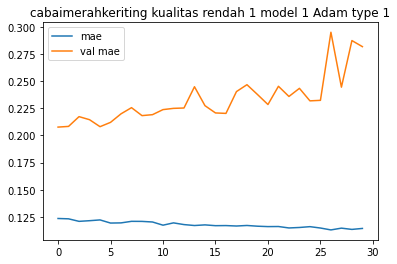

In [27]:
mae_a1 = history_a1.history['mae']
val_mae_a1 = history_a1.history['val_mae']
epoch_a1 = range(len(mae_a1))

plt.title('cabaimerahkeriting kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a1, mae_a1, label='mae')
plt.plot(epoch_a1, val_mae_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 6ms/step
7778.3506 20.69296 9489.38101247916


,actual,prediction
0,39400,46271.109375
1,38400,45139.531250
2,36000,46757.335938
3,35600,45313.335938
4,34850,46675.617188
...,...,...
229,40700,49875.101562
230,53750,49427.105469
231,50550,49146.187500
232,41200,48775.476562


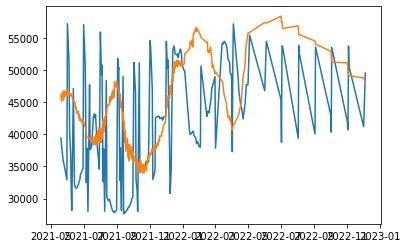

In [28]:
prediction_a1 = forecast_predict(model_a, test_cabaimerahkeriting_, time_size=win_size1, batch_size=5)

data_result_a1 = prediction_a1[(len(x_train))-win_size1:-1, -1 ]
data_result_a1 = scal_range.inverse_transform(data_result_a1.reshape(-1, 1))
data_result_a1 = data_result_a1.reshape(-1)
mae_a1= tf.keras.metrics.mean_absolute_error(x_test, data_result_a1)
mape_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a1)
mse_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result_a1)

rmse_a1 =math.sqrt(mse_a1.numpy())
print(mae_a1.numpy(), mape_a1.numpy(), rmse_a1)

data_new_cabaimerahkeriting_a1 = pd.DataFrame()
data_new_cabaimerahkeriting_a1['actual'] = x_test
data_new_cabaimerahkeriting_a1['prediction'] = data_result_a1
data_new_cabaimerahkeriting_a1.to_csv('cabaimerahkeriting_model1_adam_type2.csv')

plt.plot(y_test, data_new_cabaimerahkeriting_a1.actual)
plt.plot(y_test, data_new_cabaimerahkeriting_a1.prediction)
data_new_cabaimerahkeriting_a1

#### Type 3

In [29]:
history_a2 = model_a.fit(train_step2, epochs=30, validation_data=val_step)

Epoch 1/30
84/84 [==============================] - 11s 127ms/step - loss: 0.0300 - mae: 0.1356 - mape: 507723.0625 - val_loss: 0.1100 - val_mae: 0.2747 - val_mape: 48.5847
Epoch 2/30
84/84 [==============================] - 11s 126ms/step - loss: 0.0299 - mae: 0.1352 - mape: 502722.6875 - val_loss: 0.1051 - val_mae: 0.2679 - val_mape: 47.9781
Epoch 3/30
84/84 [==============================] - 11s 128ms/step - loss: 0.0297 - mae: 0.1344 - mape: 512831.5312 - val_loss: 0.1114 - val_mae: 0.2772 - val_mape: 48.7733
Epoch 4/30
84/84 [==============================] - 11s 125ms/step - loss: 0.0297 - mae: 0.1347 - mape: 502750.8750 - val_loss: 0.1072 - val_mae: 0.2718 - val_mape: 48.2845
Epoch 5/30
84/84 [==============================] - 11s 125ms/step - loss: 0.0297 - mae: 0.1339 - mape: 483958.4375 - val_loss: 0.0998 - val_mae: 0.2608 - val_mape: 47.2810
Epoch 6/30
84/84 [==============================] - 11s 124ms/step - loss: 0.0297 - mae: 0.1341 - mape: 513042.5000 - val_loss: 0.0986 

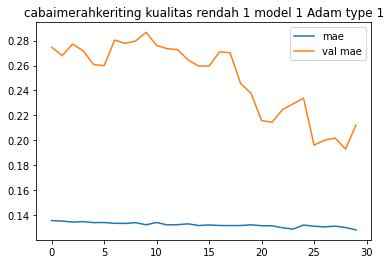

In [30]:
mae_a2 = history_a2.history['mae']
val_mae_a2 = history_a2.history['val_mae']
epoch_a2 = range(len(mae_a2))

plt.title('cabaimerahkeriting kualitas rendah 1 model 1 Adam type 1')
plt.plot(epoch_a2, mae_a2, label='mae')
plt.plot(epoch_a2, val_mae_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 2s 11ms/step
8204.62 19.969173 9438.358331828687


,actual,prediction
0,39400,43923.449219
1,38400,43047.789062
2,36000,45140.699219
3,35600,43640.339844
4,34850,46145.617188
...,...,...
229,40700,40975.070312
230,53750,40567.308594
231,50550,40759.031250
232,41200,40798.746094


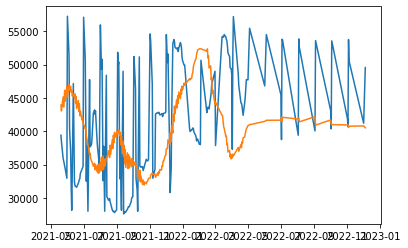

In [31]:
prediction_a2 = forecast_predict(model_a, test_cabaimerahkeriting_, time_size=win_size2, batch_size=5)

data_result_a2 = prediction_a2[(len(x_train))-win_size2:-1, -1 ]
data_result_a2 = scal_range.inverse_transform(data_result_a2.reshape(-1, 1))
data_result_a2 = data_result_a2.reshape(-1)
mae_a2= tf.keras.metrics.mean_absolute_error(x_test, data_result_a2)
mape_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result_a2)
mse_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result_a2)

rmse_a2 =math.sqrt(mse_a2.numpy())
print(mae_a2.numpy(), mape_a2.numpy(), rmse_a2)

data_new_cabaimerahkeriting_a2 = pd.DataFrame()
# data_new_cabaimerahkeriting1['date'] = date_test
data_new_cabaimerahkeriting_a2['actual'] = x_test
data_new_cabaimerahkeriting_a2['prediction'] = data_result_a2
data_new_cabaimerahkeriting_a2.to_csv('cabaimerahkeriting_model1_adam_type3.csv')

plt.plot(y_test, data_new_cabaimerahkeriting_a2.actual)
plt.plot(y_test, data_new_cabaimerahkeriting_a2.prediction)
data_new_cabaimerahkeriting_a2

## model 1

### Adam

In [32]:
model1= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss='mse', metrics=['mae', 'mape'])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_5 (LSTM)               (None, 32)                20608     
                                                                 
 dense_4 (Dense)             (None, 64)                2112      
                                                                 
 dense_5 (Dense)             (None, 128)               8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

#### Type 1

In [33]:
history1 = model1.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 18s 325ms/step - loss: 0.0412 - mae: 0.1559 - mape: 66.3655 - val_loss: 0.0636 - val_mae: 0.2138 - val_mape: 50.4216
Epoch 2/15
44/44 [==============================] - 13s 305ms/step - loss: 0.0196 - mae: 0.1214 - mape: 96.1259 - val_loss: 0.0623 - val_mae: 0.2126 - val_mape: 50.9598
Epoch 3/15
44/44 [==============================] - 13s 304ms/step - loss: 0.0185 - mae: 0.1191 - mape: 90.5967 - val_loss: 0.0631 - val_mae: 0.2134 - val_mape: 50.6840
Epoch 4/15
44/44 [==============================] - 13s 305ms/step - loss: 0.0181 - mae: 0.1193 - mape: 95.1924 - val_loss: 0.0727 - val_mae: 0.2242 - val_mape: 48.5047
Epoch 5/15
44/44 [==============================] - 13s 304ms/step - loss: 0.0178 - mae: 0.1166 - mape: 88.0220 - val_loss: 0.0658 - val_mae: 0.2160 - val_mape: 49.8163
Epoch 6/15
44/44 [==============================] - 14s 306ms/step - loss: 0.0179 - mae: 0.1172 - mape: 90.7508 - val_loss: 0.0645 - val_mae: 0.2149 - val_

17/17 [==============================] - 0s 16ms/step - loss: 0.0668 - mae: 0.2129 - mape: 29.8943


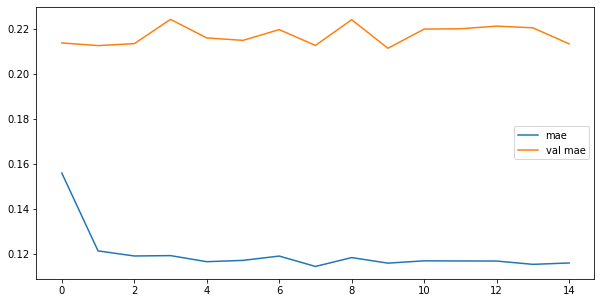

In [36]:
model1.evaluate(test_step)
mae1 = history1.history['mae']
val_mae1 = history1.history['val_mae']
epoch1 = range(len(mae1))

plt.figure(figsize=(10, 5))
plt.plot(epoch1, mae1, label='mae')
plt.plot(epoch1, val_mae1, label='val mae')
plt.legend()
plt.show()

In [37]:
prediction1 = forecast_predict(model1, test_cabaimerahkeriting_, time_size=win_size, batch_size=5)

data_result1 = prediction1[(len(x_train))-win_size:-1, -1 ]
data_result1 = scal_range.inverse_transform(data_result1.reshape(-1, 1))
data_result1 = data_result1.reshape(-1)
mae1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1)
mape1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1)
mse1 = tf.keras.metrics.mean_squared_error(x_test, data_result1)

rmse1 = math.sqrt(mse1.numpy())
print(mae1.numpy(), mape1.numpy(), rmse1)

data_new_cabaimerahkeriting1 = pd.DataFrame()
data_new_cabaimerahkeriting1['actual'] = x_test
data_new_cabaimerahkeriting1['prediction'] = data_result1
data_new_cabaimerahkeriting1.to_csv('cabaimerahkeriting_model2_adam_type1.csv')

data_new_cabaimerahkeriting1

131/131 [==============================] - 5s 31ms/step
7199.8027 16.361404 9019.635025875492


,actual,prediction
0,39400,36325.691406
1,38400,36381.203125
2,36000,36391.406250
3,35600,36431.484375
4,34850,36435.621094
...,...,...
229,40700,39874.027344
230,53750,39796.347656
231,50550,39825.621094
232,41200,39763.902344


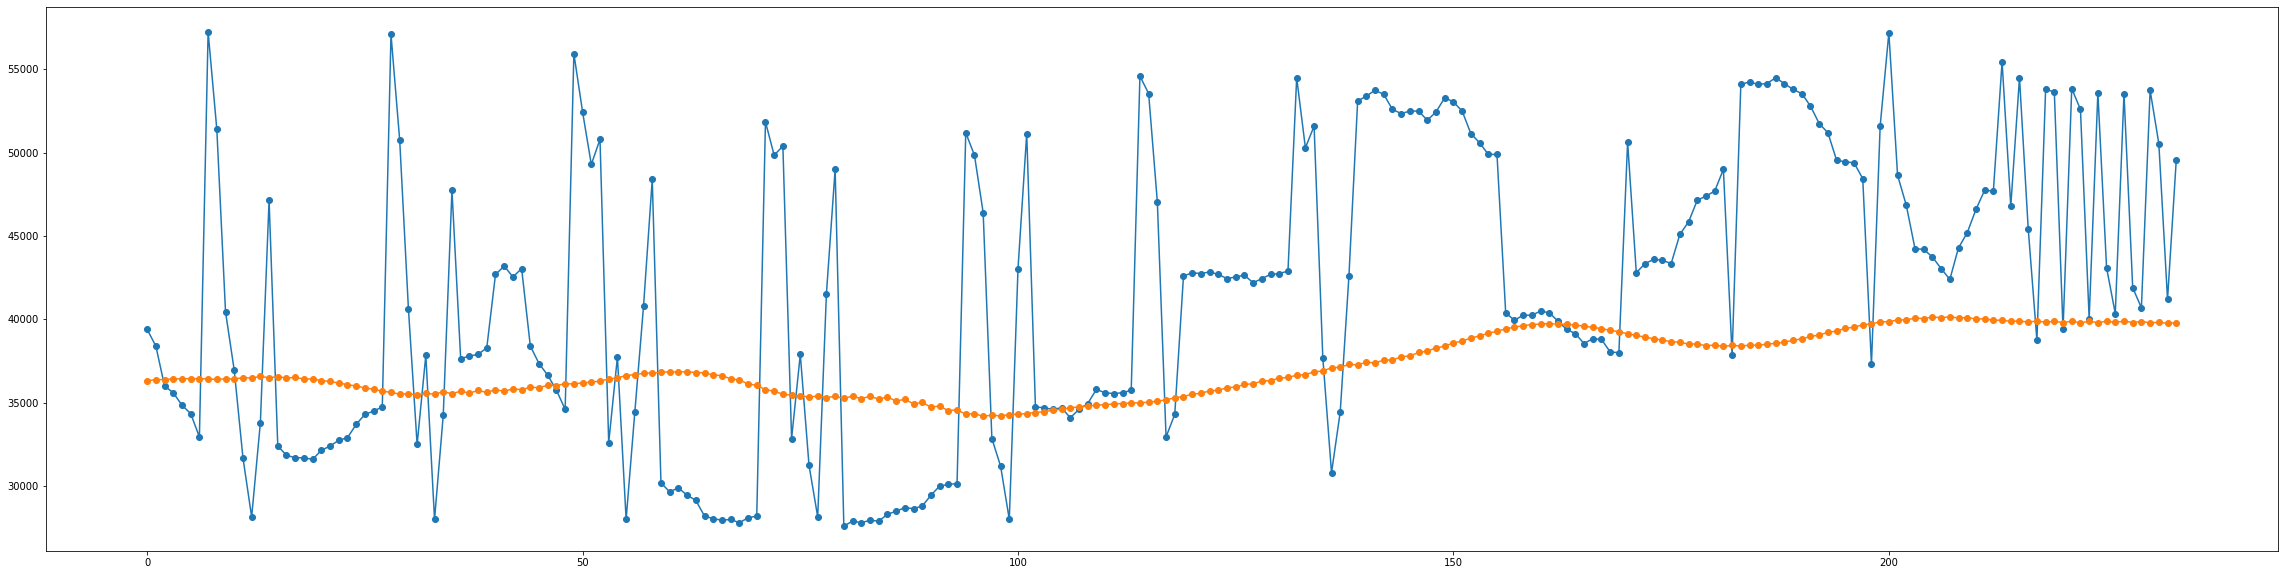

In [38]:
plt.figure(figsize=(40, 10))
plt.plot(range(len(x_test)), data_new_cabaimerahkeriting1['actual'], '-o')
plt.plot(range(len(x_test)), data_new_cabaimerahkeriting1['prediction'], '-o')

#### Type 2

In [40]:
history1_1 = model1.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 30s 41ms/step - loss: 0.0271 - mae: 0.1251 - mape: 253407.3750 - val_loss: 0.0669 - val_mae: 0.2173 - val_mape: 49.9255
Epoch 2/15
718/718 [==============================] - 30s 42ms/step - loss: 0.0259 - mae: 0.1224 - mape: 214467.2812 - val_loss: 0.0832 - val_mae: 0.2373 - val_mape: 47.9120
Epoch 3/15
718/718 [==============================] - 30s 41ms/step - loss: 0.0255 - mae: 0.1201 - mape: 283474.2500 - val_loss: 0.0697 - val_mae: 0.2198 - val_mape: 49.0793
Epoch 4/15
718/718 [==============================] - 30s 41ms/step - loss: 0.0261 - mae: 0.1221 - mape: 232835.0469 - val_loss: 0.0620 - val_mae: 0.2113 - val_mape: 51.3205
Epoch 5/15
718/718 [==============================] - 29s 41ms/step - loss: 0.0255 - mae: 0.1197 - mape: 258536.0625 - val_loss: 0.0605 - val_mae: 0.2094 - val_mape: 51.6316
Epoch 6/15
718/718 [==============================] - 29s 41ms/step - loss: 0.0257 - mae: 0.1210 - mape: 271161.5625 - val_loss: 0

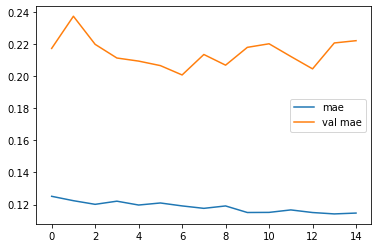

In [41]:
mae1_1 = history1_1.history['mae']
val_mae1_1 = history1_1.history['val_mae']
epoch1_1 = range(len(mae1_1))

plt.plot(epoch1_1, mae1_1, label='mae')
plt.plot(epoch1_1, val_mae1_1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 8ms/step
7238.495 16.754276 9019.635025875492


,actual,prediction
0,39400,38771.605469
1,38400,38910.710938
2,36000,38029.554688
3,35600,38299.261719
4,34850,37329.917969
...,...,...
229,40700,38925.250000
230,53750,38997.906250
231,50550,38909.414062
232,41200,39092.921875


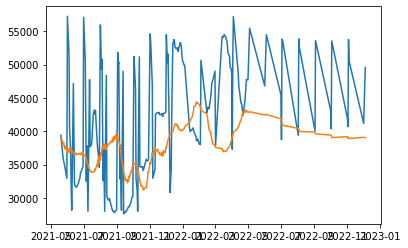

In [42]:
prediction1_1 = forecast_predict(model1, test_cabaimerahkeriting_, time_size=win_size1, batch_size=5)

data_result1_1 = prediction1_1[(len(x_train))-win_size1:-1, -1 ]
data_result1_1 = scal_range.inverse_transform(data_result1_1.reshape(-1, 1))
data_result1_1 = data_result1_1.reshape(-1)
mae1_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_1)
mape1_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_1)
mse1_1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_1)

rmse1_1 = math.sqrt(mse1.numpy())
print(mae1_1.numpy(), mape1_1.numpy(), rmse1_1)

data_new_cabaimerahkeriting1_1 = pd.DataFrame()
data_new_cabaimerahkeriting1_1['actual'] = x_test
data_new_cabaimerahkeriting1_1['prediction'] = data_result1_1
data_new_cabaimerahkeriting1_1.to_csv('cabaimerahkeriting_model2_adam_type2.csv')

plt.plot(y_test, data_new_cabaimerahkeriting1_1.actual)
plt.plot(y_test, data_new_cabaimerahkeriting1_1.prediction)
data_new_cabaimerahkeriting1_1

#### Type 3

In [43]:
history1_2 = model1.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 17s 201ms/step - loss: 0.0291 - mae: 0.1353 - mape: 599273.3125 - val_loss: 0.0664 - val_mae: 0.2116 - val_mape: 47.0785
Epoch 2/15
84/84 [==============================] - 17s 199ms/step - loss: 0.0286 - mae: 0.1331 - mape: 633647.3750 - val_loss: 0.0724 - val_mae: 0.2183 - val_mape: 45.7757
Epoch 3/15
84/84 [==============================] - 17s 200ms/step - loss: 0.0282 - mae: 0.1319 - mape: 629969.6875 - val_loss: 0.0724 - val_mae: 0.2185 - val_mape: 45.8371
Epoch 4/15
84/84 [==============================] - 17s 199ms/step - loss: 0.0280 - mae: 0.1308 - mape: 633356.5625 - val_loss: 0.0750 - val_mae: 0.2222 - val_mape: 45.7221
Epoch 5/15
84/84 [==============================] - 17s 201ms/step - loss: 0.0276 - mae: 0.1298 - mape: 622611.7500 - val_loss: 0.0764 - val_mae: 0.2241 - val_mape: 45.6630
Epoch 6/15
84/84 [==============================] - 17s 199ms/step - loss: 0.0272 - mae: 0.1280 - mape: 586304.8125 - val_loss: 0.0757 

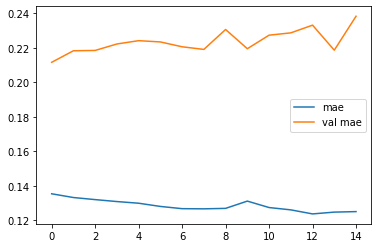

In [44]:
mae1_2 = history1_2.history['mae']
val_mae1_2 = history1_2.history['val_mae']
epoch1_2 = range(len(mae1_2))

plt.plot(epoch1_2, mae1_2, label='mae')
plt.plot(epoch1_2, val_mae1_2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 3s 14ms/step
7758.5356 17.908161 9019.635025875492


,actual,prediction
0,39400,39738.765625
1,38400,40064.046875
2,36000,38643.789062
3,35600,39125.574219
4,34850,37555.839844
...,...,...
229,40700,37892.250000
230,53750,38054.292969
231,50550,37987.128906
232,41200,38172.875000


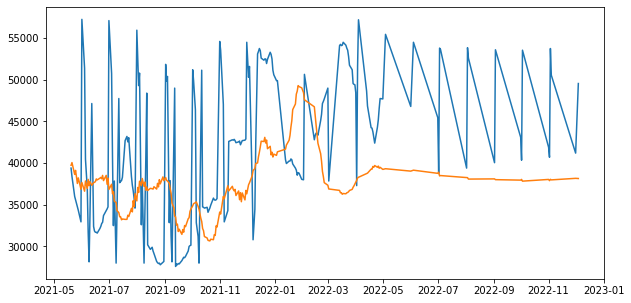

In [45]:
prediction1_2 = forecast_predict(model1, test_cabaimerahkeriting_, time_size=win_size2, batch_size=5)

data_result1_2 = prediction1_2[(len(x_train))-win_size2:-1, -1 ]
data_result1_2 = scal_range.inverse_transform(data_result1_2.reshape(-1, 1))
data_result1_2 = data_result1_2.reshape(-1)
mae1_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_2)
mape1_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_2)
mse1_2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_2)
rmse1_2 = math.sqrt(mse1.numpy())
print(mae1_2.numpy(), mape1_2.numpy(), rmse1_2)

data_new_cabaimerahkeriting1_2 = pd.DataFrame()
data_new_cabaimerahkeriting1_2['actual'] = x_test
data_new_cabaimerahkeriting1_2['prediction'] = data_result1_2
data_new_cabaimerahkeriting1_2.to_csv('cabaimerahkeriting_model2_adam_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerahkeriting1_2.actual)
plt.plot(y_test, data_new_cabaimerahkeriting1_2.prediction)

data_new_cabaimerahkeriting1_2

### SGD

In [46]:
model1_a= Sequential([
    Conv1D(16, kernel_size=5, activation='relu', strides=2, input_shape=[None, 1], padding='causal'),
    LSTM(128, return_sequences=True),
    LSTM(32),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(1)
])

model1_a.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model1_a.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 16)          96        
                                                                 
 lstm_6 (LSTM)               (None, None, 128)         74240     
                                                                 
 lstm_7 (LSTM)               (None, 32)                20608     
                                                                 
 dense_7 (Dense)             (None, 64)                2112      
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dense_9 (Dense)             (None, 1)                 129       
                                                                 
Total params: 105,505
Trainable params: 105,505
Non-tr

In [ ]:
# plot_model(model1, to_file='model2_plot.png', show_shapes=True, show_layer_names=True)

#### Type1 

In [47]:
history1_a = model1_a.fit(train_step, epochs=15, validation_data=val_step)

Epoch 1/15
44/44 [==============================] - 18s 327ms/step - loss: 0.0631 - mae: 0.2094 - mape: 88.4041 - val_loss: 0.3127 - val_mae: 0.5091 - val_mape: 89.8099
Epoch 2/15
44/44 [==============================] - 13s 301ms/step - loss: 0.0491 - mae: 0.1755 - mape: 66.5742 - val_loss: 0.2791 - val_mae: 0.4750 - val_mape: 81.5949
Epoch 3/15
44/44 [==============================] - 13s 300ms/step - loss: 0.0391 - mae: 0.1497 - mape: 56.4653 - val_loss: 0.2518 - val_mae: 0.4454 - val_mape: 74.4613
Epoch 4/15
44/44 [==============================] - 13s 299ms/step - loss: 0.0321 - mae: 0.1332 - mape: 55.1505 - val_loss: 0.2301 - val_mae: 0.4203 - val_mape: 68.4421
Epoch 5/15
44/44 [==============================] - 13s 304ms/step - loss: 0.0274 - mae: 0.1243 - mape: 58.0673 - val_loss: 0.2140 - val_mae: 0.4016 - val_mape: 64.3278
Epoch 6/15
44/44 [==============================] - 13s 304ms/step - loss: 0.0244 - mae: 0.1217 - mape: 64.6847 - val_loss: 0.2001 - val_mae: 0.3864 - val_

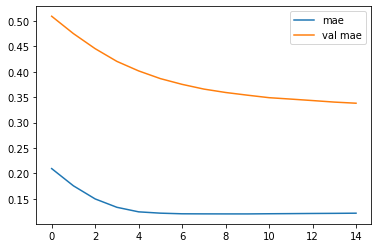

In [48]:
mae1_a = history1_a.history['mae']
val_mae1_a = history1_a.history['val_mae']
epoch1_a = range(len(mae1_a))

plt.plot(epoch1_a, mae1_a, label='mae')
plt.plot(epoch1_a, val_mae1_a, label='val mae')
plt.legend()
plt.show()

131/131 [==============================] - 5s 32ms/step
8973.646 19.78651 11047.446401770863


,actual,prediction
0,39400,34478.652344
1,38400,34466.527344
2,36000,34483.921875
3,35600,34473.316406
4,34850,34487.742188
...,...,...
229,40700,34730.742188
230,53750,34764.542969
231,50550,34727.714844
232,41200,34754.804688


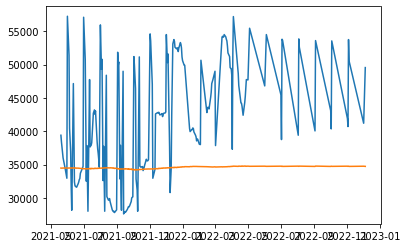

In [49]:
prediction1_a = forecast_predict(model1_a, test_cabaimerahkeriting_, time_size=win_size, batch_size=5)

data_result1_a = prediction1_a[(len(x_train))-win_size:-1, -1 ]
data_result1_a = scal_range.inverse_transform(data_result1_a.reshape(-1, 1))
data_result1_a = data_result1_a.reshape(-1)
mae1_a = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a)
mape1_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a)
mse1_a = tf.keras.metrics.mean_squared_error(x_test, data_result1_a)

rmse1_a = math.sqrt(mse1_a.numpy())
print(mae1_a.numpy(), mape1_a.numpy(), rmse1_a)

data_new_cabaimerahkeriting1_a = pd.DataFrame()
data_new_cabaimerahkeriting1_a['actual'] = x_test
data_new_cabaimerahkeriting1_a['prediction'] = data_result1_a
data_new_cabaimerahkeriting1_a.to_csv('cabaimerahkeriting_model2_sgd_type1.csv')


plt.plot(y_test, data_new_cabaimerahkeriting1_a.actual)
plt.plot(y_test, data_new_cabaimerahkeriting1_a.prediction)

data_new_cabaimerahkeriting1_a

#### Type 2


In [50]:
history1_a1 = model1_a.fit(train_step1, epochs=15, validation_data=val_step)

Epoch 1/15
718/718 [==============================] - 29s 40ms/step - loss: 0.0332 - mae: 0.1387 - mape: 296853.0000 - val_loss: 0.1228 - val_mae: 0.2967 - val_mape: 51.8621
Epoch 2/15
718/718 [==============================] - 29s 40ms/step - loss: 0.0323 - mae: 0.1370 - mape: 304518.5625 - val_loss: 0.1242 - val_mae: 0.2987 - val_mape: 52.1041
Epoch 3/15
718/718 [==============================] - 30s 41ms/step - loss: 0.0319 - mae: 0.1364 - mape: 296330.3750 - val_loss: 0.1242 - val_mae: 0.2988 - val_mape: 52.1241
Epoch 4/15
718/718 [==============================] - 29s 40ms/step - loss: 0.0316 - mae: 0.1350 - mape: 306200.6562 - val_loss: 0.1167 - val_mae: 0.2883 - val_mape: 51.1243
Epoch 5/15
718/718 [==============================] - 29s 40ms/step - loss: 0.0312 - mae: 0.1355 - mape: 295577.2812 - val_loss: 0.1098 - val_mae: 0.2789 - val_mape: 50.3715
Epoch 6/15
718/718 [==============================] - 29s 41ms/step - loss: 0.0310 - mae: 0.1342 - mape: 294073.9062 - val_loss: 0

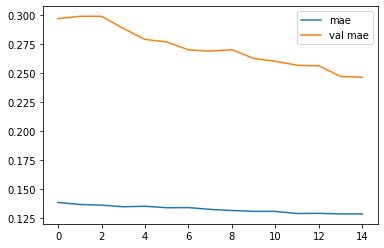

In [51]:
mae1_a1 = history1_a1.history['mae']
val_mae1_a1 = history1_a1.history['val_mae']
epoch1_a1 = range(len(mae1_a1))

plt.plot(epoch1_a1, mae1_a1, label='mae')
plt.plot(epoch1_a1, val_mae1_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 2s 8ms/step
7935.612 17.7094 9869.836878084663


,actual,prediction
0,39400,35411.949219
1,38400,35393.699219
2,36000,35448.910156
3,35600,35427.460938
4,34850,35469.238281
...,...,...
229,40700,37558.324219
230,53750,37580.078125
231,50550,37507.804688
232,41200,37577.554688


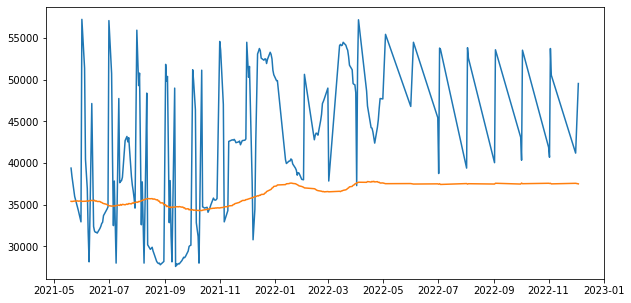

In [52]:
prediction1_a1 = forecast_predict(model1_a, test_cabaimerahkeriting_, time_size=win_size1, batch_size=5)

data_result1_a1 = prediction1_a1[(len(x_train))-win_size1:-1, -1 ]
data_result1_a1 = scal_range.inverse_transform(data_result1_a1.reshape(-1, 1))
data_result1_a1 = data_result1_a1.reshape(-1)
mae1_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a1)
mape1_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a1)
mse1_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a1)

rmse1_a1 = math.sqrt(mse1_a1.numpy())
print(mae1_a1.numpy(), mape1_a1.numpy(), rmse1_a1)

data_new_cabaimerahkeriting1_a1 = pd.DataFrame()
data_new_cabaimerahkeriting1_a1['actual'] = x_test
data_new_cabaimerahkeriting1_a1['prediction'] = data_result1_a1
data_new_cabaimerahkeriting1_a1.to_csv('cabaimerahkeriting_model2_sgd_type2.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerahkeriting1_a1.actual)
plt.plot(y_test, data_new_cabaimerahkeriting1_a1.prediction)
data_new_cabaimerahkeriting1_a1

#### Type 3

In [53]:
history1_a2 = model1_a.fit(train_step2, epochs=15, validation_data=val_step)

Epoch 1/15
84/84 [==============================] - 18s 215ms/step - loss: 0.0391 - mae: 0.1556 - mape: 534015.0000 - val_loss: 0.0816 - val_mae: 0.2360 - val_mape: 47.8557
Epoch 2/15
84/84 [==============================] - 17s 204ms/step - loss: 0.0383 - mae: 0.1556 - mape: 546623.7500 - val_loss: 0.0791 - val_mae: 0.2321 - val_mape: 47.7552
Epoch 3/15
84/84 [==============================] - 17s 204ms/step - loss: 0.0382 - mae: 0.1563 - mape: 570344.5625 - val_loss: 0.0777 - val_mae: 0.2302 - val_mape: 47.8245
Epoch 4/15
84/84 [==============================] - 17s 205ms/step - loss: 0.0380 - mae: 0.1560 - mape: 572944.9375 - val_loss: 0.0763 - val_mae: 0.2286 - val_mape: 47.9593
Epoch 5/15
84/84 [==============================] - 17s 206ms/step - loss: 0.0380 - mae: 0.1560 - mape: 570867.5625 - val_loss: 0.0760 - val_mae: 0.2282 - val_mape: 48.0039
Epoch 6/15
84/84 [==============================] - 17s 204ms/step - loss: 0.0378 - mae: 0.1556 - mape: 572263.7500 - val_loss: 0.0755 

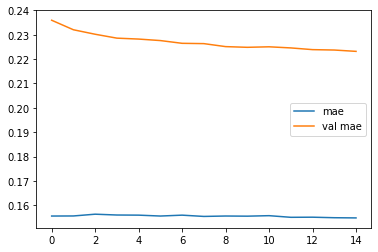

In [54]:
mae1_a2 = history1_a2.history['mae']
val_mae1_a2 = history1_a2.history['val_mae']
epoch1_a2 = range(len(mae1_a2))

plt.plot(epoch1_a2, mae1_a2, label='mae')
plt.plot(epoch1_a2, val_mae1_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 3s 15ms/step
7325.2285 16.706326 9110.225902797361


,actual,prediction
0,39400,36562.789062
1,38400,36543.007812
2,36000,36606.226562
3,35600,36582.816406
4,34850,36629.640625
...,...,...
229,40700,39239.578125
230,53750,39260.992188
231,50550,39181.625000
232,41200,39258.871094


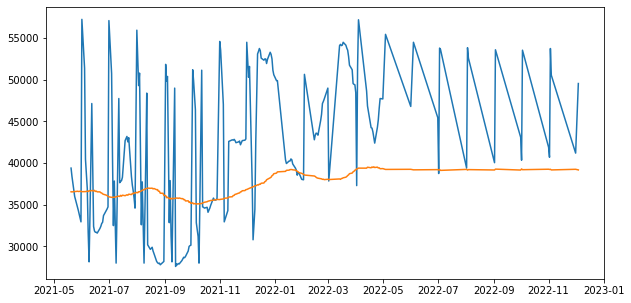

In [55]:
prediction1_a2 = forecast_predict(model1_a, test_cabaimerahkeriting_, time_size=win_size2, batch_size=5)

data_result1_a2 = prediction1_a2[(len(x_train))-win_size2:-1, -1 ]
data_result1_a2 = scal_range.inverse_transform(data_result1_a2.reshape(-1, 1))
data_result1_a2 = data_result1_a2.reshape(-1)
mae1_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result1_a2)
mape1_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result1_a2)
mse1_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result1_a2)

rmse1_a2 = math.sqrt(mse1_a2.numpy())
print(mae1_a2.numpy(), mape1_a2.numpy(), rmse1_a2)

data_new_cabaimerahkeriting1_a2 = pd.DataFrame()
data_new_cabaimerahkeriting1_a2['actual'] = x_test
data_new_cabaimerahkeriting1_a2['prediction'] = data_result1_a2
data_new_cabaimerahkeriting1_a2.to_csv('cabaimerahkeriting_model2_sgd_type3.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerahkeriting1_a2.actual)
plt.plot(y_test, data_new_cabaimerahkeriting1_a2.prediction)

data_new_cabaimerahkeriting1_a2

## model 2

### SGD

In [56]:
model2= Sequential([
    Conv1D(8, kernel_size=5, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(14, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dense(24, activation='relu'),
    Dense(550, activation='relu'),
    Dense(1)
])

model2.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-4, momentum=0.9), loss='mse', metrics=['mae', 'mape'])
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 8)           48        
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 8)          0         
 )                                                               
                                                                 
 lstm_8 (LSTM)               (None, None, 14)          1288      
                                                                 
 dropout (Dropout)           (None, None, 14)          0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                20224     
                                                                 
 dense_10 (Dense)            (None, 24)                1560      
                                                      

In [ ]:
# plot_model(model2, to_file='model3_plot.png', show_shapes=True, show_layer_names=True)

#### Type 1

In [57]:
history2 = model2.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 9s 128ms/step - loss: 0.0641 - mae: 0.2126 - mape: 90.7121 - val_loss: 0.3231 - val_mae: 0.5194 - val_mape: 92.2861
Epoch 2/50
44/44 [==============================] - 6s 129ms/step - loss: 0.0509 - mae: 0.1795 - mape: 67.8767 - val_loss: 0.2901 - val_mae: 0.4866 - val_mape: 84.3954
Epoch 3/50
44/44 [==============================] - 5s 105ms/step - loss: 0.0414 - mae: 0.1555 - mape: 58.1444 - val_loss: 0.2641 - val_mae: 0.4590 - val_mape: 77.7687
Epoch 4/50
44/44 [==============================] - 5s 105ms/step - loss: 0.0347 - mae: 0.1391 - mape: 55.1165 - val_loss: 0.2441 - val_mae: 0.4367 - val_mape: 72.3982
Epoch 5/50
44/44 [==============================] - 5s 105ms/step - loss: 0.0301 - mae: 0.1295 - mape: 56.3995 - val_loss: 0.2285 - val_mae: 0.4185 - val_mape: 68.0064
Epoch 6/50
44/44 [==============================] - 5s 106ms/step - loss: 0.0269 - mae: 0.1242 - mape: 60.1109 - val_loss: 0.2153 - val_mae: 0.4031 - val_mape: 

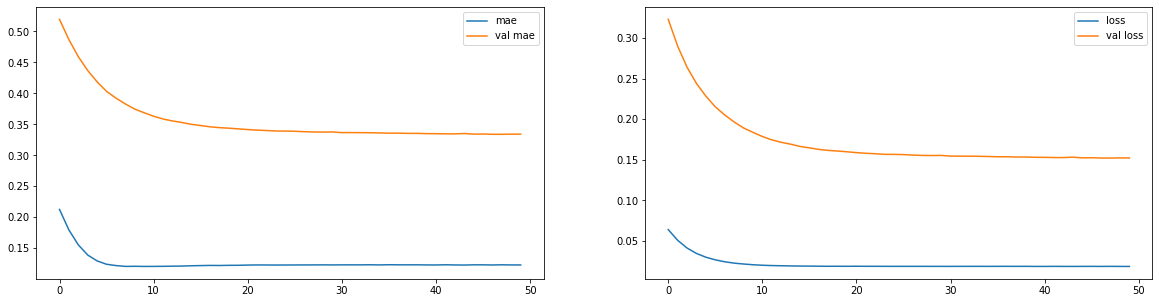

In [58]:
mae2 = history2.history['mae']
val_mae2 = history2.history['val_mae']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']
epoch2 = range(len(mae2))

plt.figure(figsize=(20, 5))
plt.subplot(1,2, 1)
plt.plot(epoch2, mae2, label='mae')
plt.plot(epoch2, val_mae2, label='val mae')
plt.legend()
plt.subplot(1,2,2)
plt.plot(epoch2, loss2, label='loss')
plt.plot(epoch2, val_loss2, label='val loss')
plt.legend()
plt.show()

131/131 [==============================] - 3s 15ms/step
8881.65 19.647097 10920.655291693809


,actual,prediction
0,39400,34616.910156
1,38400,34648.488281
2,36000,34620.257812
3,35600,34619.742188
4,34850,34631.324219
...,...,...
229,40700,34971.304688
230,53750,34952.593750
231,50550,34967.671875
232,41200,34939.699219


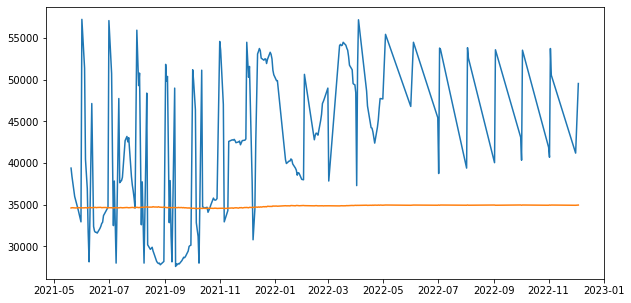

In [59]:
prediction2 = forecast_predict(model2, test_cabaimerahkeriting_, time_size=win_size, batch_size=5)

data_result2 = prediction2[(len(x_train))-win_size:-1, -1 ]
data_result2 = scal_range.inverse_transform(data_result2.reshape(-1, 1))
data_result2 = data_result2.reshape(-1)
mae2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2)
mape2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2)
mse2 = tf.keras.metrics.mean_squared_error(x_test, data_result2)

rmse2 = math.sqrt(mse2.numpy())
print(mae2.numpy(), mape2.numpy(), rmse2)

data_new_cabaimerahkeriting2 = pd.DataFrame()
data_new_cabaimerahkeriting2['actual'] = x_test
data_new_cabaimerahkeriting2['prediction'] = data_result2
data_new_cabaimerahkeriting2.to_csv('cabaimerahkeriting_medium_model3_sgd_type1.csv')

plt.figure(figsize=(10, 5))
plt.plot(y_test, data_new_cabaimerahkeriting2.actual)
plt.plot(y_test, data_new_cabaimerahkeriting2.prediction)
data_new_cabaimerahkeriting2

#### Type2

In [60]:
history2_1 = model2.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 15s 20ms/step - loss: 0.0336 - mae: 0.1394 - mape: 298744.3438 - val_loss: 0.1305 - val_mae: 0.3070 - val_mape: 52.8364
Epoch 2/50
718/718 [==============================] - 14s 20ms/step - loss: 0.0332 - mae: 0.1386 - mape: 408738.3750 - val_loss: 0.1287 - val_mae: 0.3046 - val_mape: 52.6027
Epoch 3/50
718/718 [==============================] - 14s 20ms/step - loss: 0.0330 - mae: 0.1382 - mape: 365795.7812 - val_loss: 0.1265 - val_mae: 0.3016 - val_mape: 52.3028
Epoch 4/50
718/718 [==============================] - 14s 20ms/step - loss: 0.0329 - mae: 0.1388 - mape: 306488.2812 - val_loss: 0.1251 - val_mae: 0.2998 - val_mape: 52.1179
Epoch 5/50
718/718 [==============================] - 14s 20ms/step - loss: 0.0330 - mae: 0.1376 - mape: 320385.2188 - val_loss: 0.1245 - val_mae: 0.2990 - val_mape: 52.0399
Epoch 6/50
718/718 [==============================] - 14s 20ms/step - loss: 0.0328 - mae: 0.1377 - mape: 302071.6562 - val_loss: 0

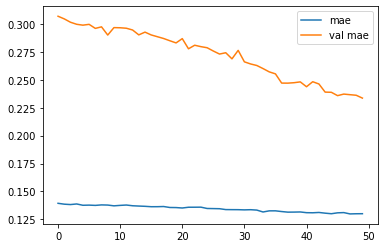

In [61]:
mae2_1 = history2_1.history['mae']
val_mae2_1 = history2_1.history['val_mae']
epoch2_1 = range(len(mae2_1))

plt.plot(epoch2_1, mae2_1, label='mae')
plt.plot(epoch2_1, val_mae2_1, label='val mae')
plt.legend()
plt.show()

In [62]:
prediction2_1 = forecast_predict(model2, test_cabaimerahkeriting_, time_size=win_size1, batch_size=5)

data_result2_1 = prediction2_1[(len(x_train))-win_size1:-1, -1 ]
data_result2_1 = scal_range.inverse_transform(data_result2_1.reshape(-1, 1))
data_result2_1 = data_result2_1.reshape(-1)
mae2_1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_1)
mape2_1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_1)
mse2_1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_1)

rmse2_1 = math.sqrt(mse2_1.numpy())
print(mae2_1.numpy(), mape2_1.numpy(), rmse2_1)

data_new_cabaimerahkeriting2_1 = pd.DataFrame()
data_new_cabaimerahkeriting2_1['actual'] = x_test
data_new_cabaimerahkeriting2_1['prediction'] = data_result2_1
data_new_cabaimerahkeriting2_1.to_csv('cabaimerahkeriting_model3_sgd_type2.csv')

data_new_cabaimerahkeriting2

199/199 [==============================] - 1s 4ms/step
8064.768 18.022861 9990.692868865503


,actual,prediction
0,39400,34616.910156
1,38400,34648.488281
2,36000,34620.257812
3,35600,34619.742188
4,34850,34631.324219
...,...,...
229,40700,34971.304688
230,53750,34952.593750
231,50550,34967.671875
232,41200,34939.699219


#### Type 3

In [63]:
history2_2 = model2.fit(train_step2, epochs=50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 6s 72ms/step - loss: 0.0394 - mae: 0.1553 - mape: 516080.7500 - val_loss: 0.0759 - val_mae: 0.2278 - val_mape: 47.8208
Epoch 2/50
84/84 [==============================] - 6s 71ms/step - loss: 0.0392 - mae: 0.1568 - mape: 540680.0625 - val_loss: 0.0738 - val_mae: 0.2252 - val_mape: 48.0284
Epoch 3/50
84/84 [==============================] - 6s 71ms/step - loss: 0.0390 - mae: 0.1571 - mape: 549597.5625 - val_loss: 0.0730 - val_mae: 0.2242 - val_mape: 48.1134
Epoch 4/50
84/84 [==============================] - 6s 72ms/step - loss: 0.0388 - mae: 0.1572 - mape: 560447.4375 - val_loss: 0.0726 - val_mae: 0.2238 - val_mape: 48.1544
Epoch 5/50
84/84 [==============================] - 6s 73ms/step - loss: 0.0393 - mae: 0.1577 - mape: 565476.8750 - val_loss: 0.0720 - val_mae: 0.2230 - val_mape: 48.2178
Epoch 6/50
84/84 [==============================] - 6s 72ms/step - loss: 0.0392 - mae: 0.1580 - mape: 563702.0625 - val_loss: 0.0720 - val_mae: 0

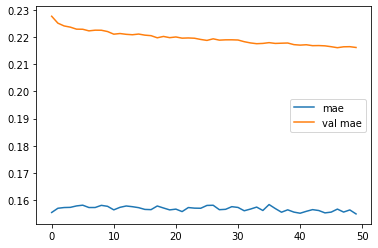

In [64]:
mae2_2 = history2_2.history['mae']
val_mae2_2 = history2_2.history['val_mae']
epoch2_2 = range(len(mae2_2))

plt.plot(epoch2_2, mae2_2, label='mae')
plt.plot(epoch2_2, val_mae2_2, label='val mae')
plt.legend()
plt.show()

In [65]:
prediction2_2 = forecast_predict(model2, test_cabaimerahkeriting_, time_size=win_size2, batch_size=5)

data_result2_2 = prediction2_2[(len(x_train))-win_size2:-1, -1 ]
data_result2_2 = scal_range.inverse_transform(data_result2_2.reshape(-1, 1))
data_result2_2 = data_result2_2.reshape(-1)
mae2_2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_2)
mape2_2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_2)
mse2_2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_2)

rmse2_2 = math.sqrt(mse2_2.numpy())
print(mae2_2.numpy(), mape2_2.numpy(), rmse2_2)

data_new_cabaimerahkeriting2_2 = pd.DataFrame()
data_new_cabaimerahkeriting2_2['actual'] = x_test
data_new_cabaimerahkeriting2_2['prediction'] = data_result2_2
data_new_cabaimerahkeriting2_2.to_csv('cabaimerahkeriting_model3_sgd-type3.csv')

data_new_cabaimerahkeriting2_2

181/181 [==============================] - 1s 7ms/step
7445.9023 16.937313 9251.826198108134


,actual,prediction
0,39400,35891.503906
1,38400,35980.363281
2,36000,35937.769531
3,35600,36095.972656
4,34850,35950.472656
...,...,...
229,40700,39363.429688
230,53750,39191.332031
231,50550,39358.199219
232,41200,39345.355469


### Adam

In [66]:
model2_a= Sequential([
    Conv1D(16, kernel_size=2, 
                            activation='relu',strides=2,
                            padding='causal', input_shape=[None, 1]),
    tf.keras.layers.MaxPool1D(2, padding="same"),
    LSTM(24, return_sequences=True),
    Dropout(0.3),
    LSTM(80),
    Dense(24, activation='relu'),
    Dense(50, activation='relu'),
    Dense(1)
])

model2_a.compile(loss= 'mean_squared_error', optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), metrics=['mae', 'mape'])
model2_a.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_5 (Conv1D)           (None, None, 16)          48        
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 lstm_10 (LSTM)              (None, None, 24)          3936      
                                                                 
 dropout_1 (Dropout)         (None, None, 24)          0         
                                                                 
 lstm_11 (LSTM)              (None, 80)                33600     
                                                                 
 dense_13 (Dense)            (None, 24)                1944      
                                                      

#### type 1

In [67]:
history2_a = model2_a.fit(train_step, epochs=50, validation_data=val_step)

Epoch 1/50
44/44 [==============================] - 10s 137ms/step - loss: 0.0633 - mae: 0.2100 - mape: 88.6686 - val_loss: 0.3049 - val_mae: 0.5015 - val_mape: 87.9880
Epoch 2/50
44/44 [==============================] - 5s 115ms/step - loss: 0.0333 - mae: 0.1437 - mape: 72.4237 - val_loss: 0.1908 - val_mae: 0.3760 - val_mape: 60.1964
Epoch 3/50
44/44 [==============================] - 5s 115ms/step - loss: 0.0186 - mae: 0.1194 - mape: 91.1268 - val_loss: 0.1743 - val_mae: 0.3582 - val_mape: 57.9818
Epoch 4/50
44/44 [==============================] - 5s 115ms/step - loss: 0.0188 - mae: 0.1175 - mape: 85.4170 - val_loss: 0.1566 - val_mae: 0.3389 - val_mape: 56.0364
Epoch 5/50
44/44 [==============================] - 5s 115ms/step - loss: 0.0200 - mae: 0.1232 - mape: 93.7930 - val_loss: 0.1699 - val_mae: 0.3536 - val_mape: 57.5216
Epoch 6/50
44/44 [==============================] - 5s 115ms/step - loss: 0.0184 - mae: 0.1227 - mape: 96.6876 - val_loss: 0.1692 - val_mae: 0.3528 - val_mape:

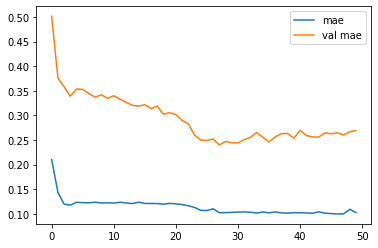

In [68]:
mae2_a = history2_a.history['mae']
val_mae2_a = history2_a.history['val_mae']
epoch2_a = range(len(mae2_a))

plt.plot(epoch2_a, mae2_a, label='mae')
plt.plot(epoch2_a, val_mae2_a, label='val mae')
plt.legend()
plt.show()

In [69]:
prediction2_a = forecast_predict(model2_a, test_cabaimerahkeriting_, time_size=win_size, batch_size=5)

data_result2_a = prediction2_a[(len(x_train))-win_size:-1, -1 ]
data_result2_a = scal_range.inverse_transform(data_result2_a.reshape(-1, 1))
data_result2_a = data_result2_a.reshape(-1)
mae2_a = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a)
mape2_a = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a)
mse2_a = tf.keras.metrics.mean_squared_error(x_test, data_result2_a)

rmse2_a = math.sqrt(mse2_a.numpy())
print(mae2_a.numpy(), mape2_a.numpy(), rmse2_a)

data_new_cabaimerahkeriting2_a = pd.DataFrame()
data_new_cabaimerahkeriting2_a['actual'] = x_test
data_new_cabaimerahkeriting2_a['prediction'] = data_result2_a
data_new_cabaimerahkeriting2_a.to_csv('cabaimerahkeriting_model3_adam-type1.csv')

data_new_cabaimerahkeriting2_a

131/131 [==============================] - 3s 15ms/step
8052.151 18.5931 9682.505460881497


,actual,prediction
0,39400,36245.242188
1,38400,36214.437500
2,36000,36459.972656
3,35600,36382.441406
4,34850,36329.851562
...,...,...
229,40700,37692.464844
230,53750,37957.519531
231,50550,37714.375000
232,41200,37890.457031


#### Type 2

In [70]:
history2_a1 = model2_a.fit(train_step1, epochs=50, validation_data=val_step)

Epoch 1/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0317 - mae: 0.1365 - mape: 212906.3438 - val_loss: 0.0966 - val_mae: 0.2593 - val_mape: 48.8405
Epoch 2/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0293 - mae: 0.1305 - mape: 392527.9062 - val_loss: 0.0792 - val_mae: 0.2320 - val_mape: 47.6493
Epoch 3/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0287 - mae: 0.1287 - mape: 295927.0000 - val_loss: 0.0705 - val_mae: 0.2215 - val_mape: 48.7350
Epoch 4/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0282 - mae: 0.1283 - mape: 373228.0625 - val_loss: 0.0662 - val_mae: 0.2170 - val_mape: 49.8476
Epoch 5/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0275 - mae: 0.1261 - mape: 303838.9062 - val_loss: 0.0638 - val_mae: 0.2149 - val_mape: 50.7114
Epoch 6/50
718/718 [==============================] - 15s 21ms/step - loss: 0.0270 - mae: 0.1240 - mape: 473274.4375 - val_loss: 0

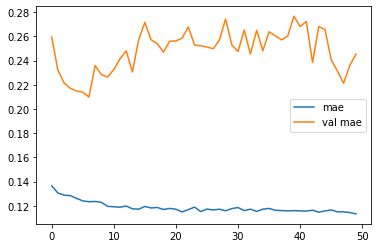

In [71]:
mae2_a1 = history2_a1.history['mae']
val_mae2_a1 = history2_a1.history['val_mae']
epoch2_a1 = range(len(mae2_a1))

plt.plot(epoch2_a1, mae2_a1, label='mae')
plt.plot(epoch2_a1, val_mae2_a1, label='val mae')
plt.legend()
plt.show()

199/199 [==============================] - 1s 4ms/step
6835.399 16.596233 8224.670206154165


,actual,prediction
0,39400,37088.089844
1,38400,34870.785156
2,36000,37523.871094
3,35600,35803.945312
4,34850,37284.101562
...,...,...
229,40700,44969.105469
230,53750,43840.792969
231,50550,44661.339844
232,41200,44739.089844


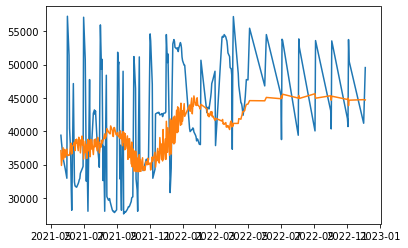

In [72]:
prediction2_a1 = forecast_predict(model2_a, test_cabaimerahkeriting_, time_size=win_size1, batch_size=5)

data_result2_a1 = prediction2_a1[(len(x_train))-win_size1:-1, -1 ]
data_result2_a1 = scal_range.inverse_transform(data_result2_a1.reshape(-1, 1))
data_result2_a1 = data_result2_a1.reshape(-1)
mae2_a1 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a1)
mape2_a1 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a1)
mse2_a1 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a1)

rmse2_a1 = math.sqrt(mse2_a1.numpy())
print(mae2_a1.numpy(), mape2_a1.numpy(), rmse2_a1)

data_new_cabaimerahkeriting2_a1 = pd.DataFrame()
data_new_cabaimerahkeriting2_a1['actual'] = x_test
data_new_cabaimerahkeriting2_a1['prediction'] = data_result2_a1
data_new_cabaimerahkeriting2_a1.to_csv('cabaimerahkeriting_model3_adam-type2.csv')

plt.plot(y_test, data_new_cabaimerahkeriting2_a1.actual)
plt.plot(y_test, data_new_cabaimerahkeriting2_a1.prediction)
data_new_cabaimerahkeriting2_a1

#### Type 3

In [73]:
history2_a2 = model2_a.fit(train_step2, epochs= 50, validation_data=val_step)

Epoch 1/50
84/84 [==============================] - 7s 80ms/step - loss: 0.0360 - mae: 0.1521 - mape: 594301.3125 - val_loss: 0.0931 - val_mae: 0.2533 - val_mape: 48.2184
Epoch 2/50
84/84 [==============================] - 7s 80ms/step - loss: 0.0319 - mae: 0.1431 - mape: 599012.6875 - val_loss: 0.0855 - val_mae: 0.2412 - val_mape: 47.5646
Epoch 3/50
84/84 [==============================] - 7s 81ms/step - loss: 0.0313 - mae: 0.1420 - mape: 557453.7500 - val_loss: 0.0848 - val_mae: 0.2402 - val_mape: 47.6034
Epoch 4/50
84/84 [==============================] - 7s 80ms/step - loss: 0.0309 - mae: 0.1401 - mape: 528776.4375 - val_loss: 0.0858 - val_mae: 0.2416 - val_mape: 47.6685
Epoch 5/50
84/84 [==============================] - 7s 80ms/step - loss: 0.0305 - mae: 0.1390 - mape: 615679.5625 - val_loss: 0.0843 - val_mae: 0.2394 - val_mape: 47.4990
Epoch 6/50
84/84 [==============================] - 7s 80ms/step - loss: 0.0308 - mae: 0.1391 - mape: 553686.8125 - val_loss: 0.0838 - val_mae: 0

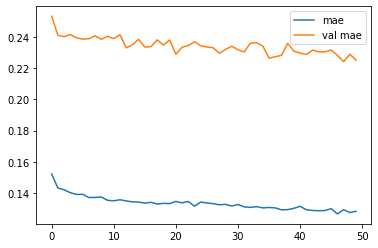

In [74]:
mae2_a2 = history2_a2.history['mae']
val_mae2_a2 = history2_a2.history['val_mae']
epoch2_a2 = range(len(mae2_a2))

plt.plot(epoch2_a2, mae2_a2, label='mae')
plt.plot(epoch2_a2, val_mae2_a2, label='val mae')
plt.legend()
plt.show()

181/181 [==============================] - 1s 8ms/step
7908.578 17.949669 9718.23852351855


,actual,prediction
0,39400,36891.113281
1,38400,36656.957031
2,36000,36994.500000
3,35600,36028.339844
4,34850,37730.617188
...,...,...
229,40700,36948.515625
230,53750,36981.535156
231,50550,37021.679688
232,41200,36874.437500


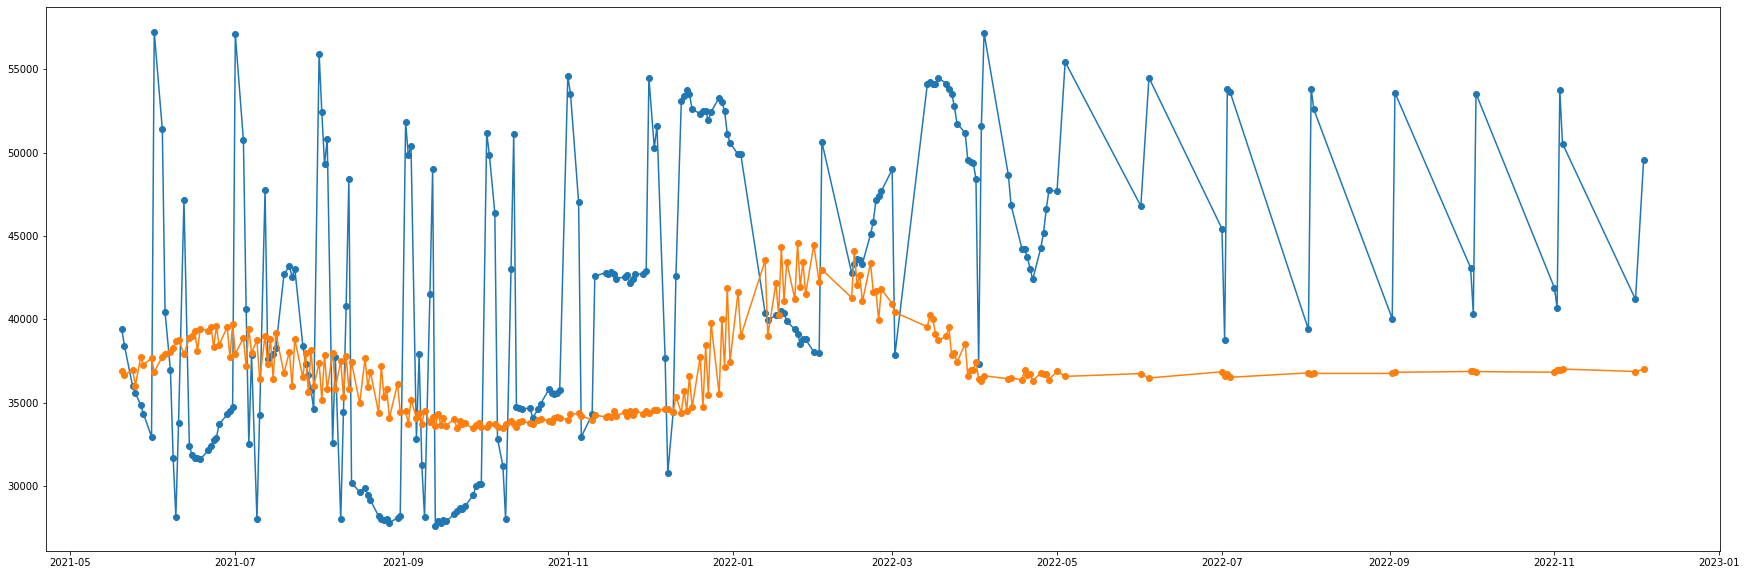

In [75]:
prediction2_a2 = forecast_predict(model2_a, test_cabaimerahkeriting_, time_size=win_size2, batch_size=5)

data_result2_a2 = prediction2_a2[(len(x_train))-win_size2:-1, -1 ]
data_result2_a2 = scal_range.inverse_transform(data_result2_a2.reshape(-1, 1))
data_result2_a2 = data_result2_a2.reshape(-1)
mae2_a2 = tf.keras.metrics.mean_absolute_error(x_test, data_result2_a2)
mape2_a2 = tf.keras.metrics.mean_absolute_percentage_error(x_test, data_result2_a2)
mse2_a2 = tf.keras.metrics.mean_squared_error(x_test, data_result2_a2)

rmse2_a2 = math.sqrt(mse2_a2.numpy())
print(mae2_a2.numpy(), mape2_a2.numpy(), rmse2_a2)

data_new_cabaimerahkeriting2_a2 = pd.DataFrame()
data_new_cabaimerahkeriting2_a2['actual'] = x_test
data_new_cabaimerahkeriting2_a2['prediction'] = data_result2_a2
data_new_cabaimerahkeriting2_a2.to_csv('cabaimerahkeriting_model3_adam_type3.csv')

plt.figure(figsize=(30, 10))
plt.plot(y_test,data_new_cabaimerahkeriting2_a2.actual, '-o')
plt.plot(y_test,data_new_cabaimerahkeriting2_a2.prediction, '-o')
data_new_cabaimerahkeriting2_a2